Marklin Example 1: Compute and trace Taylor states in an elongated cylinder {#doc_marklin_ex1}
==========
In this example we compute the Taylor state in a R=1, L=10 cylinder with Marklin and then demonstrate tracing the magnetic field and the vector potential.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Marklin library

To load the Marklin python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.Marklin import Marklin

In [3]:
taylor_solver = Marklin()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   Marklin_vacuum
Revision id:          8b643f3
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
taylor_solver.setup_mesh(mesh_file='cyl10_mesh.h5')


**** Loading OFT mesh
  Mesh File = cyl10_mesh.h5

**** Generating grid level  1
  Generating domain linkage
  Generating boundary domain linkage
  Mesh statistics:
    Volume          =  3.125E+01
    Surface area    =  6.899E+01
    # of points     =    6867
    # of edges      =   43660
    # of faces      =   71594
    # of cells      =   34800
    # of boundary points =    1996
    # of boundary edges  =    5982
    # of boundary faces  =    3988
    # of boundary cells  =    3928
  Resolution statistics:
    hmin =  1.101E-01
    hrms =  2.077E-01
    hmax =  3.575E-01
  Surface grounded at vertex    1482



In [5]:
taylor_solver.compute(1,2)


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1


**** Creating Nedelec H1(Curl) FE space
  Order  =    2
  Minlev =   -1


**** Creating Nedelec H0 FE space
  Order  =    3
  Minlev =   -1


**** Creating Nedelec H1 FE space
  Order  =    2
  Minlev =   -1


Starting calculation of Taylor states

 Reading "hffa" from file "hffa_r01_p02_m01.rst"
Starting CG eigensolver
     0  3.161823E+00  5.675209E-15
     1  3.161823E+00  7.754230E-17
     2  3.161823E+00  4.567300E-16
     3  3.161823E+00  2.044771E-14
     4  3.161823E+00  7.230184E-15
     5  3.161823E+00  3.568664E-15
     6  3.161823E+00  3.604079E-15
Starting CG solver
     0  0.000000E+00  0.000000E+00  8.488126E-09
     1 -3.698285E-17  8.745035E-09  3.489829E-09  3.990641E-01
     2 -4.558361E-17  1.187705E-08  1.993379E-09  1.678345E-01
     3 -4.870331E-17  1.372746E-08  1.328592E-09  9.678356E-02
     4 -5.025844E-17  1.509191E-08  1.014621E-09  6.722946E-02
     5 -5.123915E-17  1.628463E-08  8.147989E-

In [6]:
taylor_solver.save_visit()

Starting CG solver
     0  0.000000E+00  0.000000E+00  3.677398E-02
     1 -4.452315E-01  2.524066E+01  4.012824E-03  1.589825E-04
     2 -4.880993E-01  3.430796E+01  4.325485E-03  1.260782E-04
     3 -4.991047E-01  3.870506E+01  9.354134E-04  2.416773E-05
     4 -4.997271E-01  3.899975E+01  4.154265E-04  1.065203E-05
     5 -4.999018E-01  3.912772E+01  2.321384E-04  5.932837E-06
     6 -4.999504E-01  3.916347E+01  1.306424E-04  3.335822E-06
     7 -4.999650E-01  3.917628E+01  7.177412E-05  1.832081E-06
     8 -4.999690E-01  3.918463E+01  3.993373E-05  1.019117E-06
     9 -4.999704E-01  3.918628E+01  2.359862E-05  6.022166E-07
    10 -4.999708E-01  3.918761E+01  1.262058E-05  3.220554E-07
    20 -4.999710E-01  3.918895E+01  4.984754E-08  1.271980E-09
    30 -4.999710E-01  3.918896E+01  3.227181E-10  8.234922E-12


In [7]:
ainterp_obj = taylor_solver.get_ainterp(hmode_facs=np.r_[1.0,])
binterp_obj = taylor_solver.get_binterp(hmode_facs=np.r_[1.0,])

 Setting gauge
Starting CG solver
     0  0.000000E+00  0.000000E+00  5.445644E-02
     1 -4.667476E-03  7.787533E-01  3.795519E-02  4.873841E-02
     2 -9.035442E-03  6.936667E-01  4.253820E-02  6.132369E-02
     3 -1.170193E-02  1.232675E+00  4.183387E-02  3.393746E-02
     4 -1.430521E-02  1.756316E+00  4.054627E-02  2.308597E-02
     5 -1.708825E-02  2.031936E+00  3.800052E-02  1.870163E-02
     6 -1.905860E-02  2.076333E+00  3.969366E-02  1.911719E-02
     7 -2.123636E-02  2.178583E+00  3.573192E-02  1.640145E-02
     8 -2.278647E-02  2.347567E+00  2.935818E-02  1.250579E-02
     9 -2.408988E-02  2.487577E+00  2.419455E-02  9.726152E-03
    10 -2.494267E-02  2.530275E+00  1.943457E-02  7.680813E-03
    20 -2.733086E-02  1.584154E+00  4.453604E-03  2.811346E-03
    30 -2.742610E-02  1.564997E+00  9.219291E-04  5.890930E-04
    40 -2.743179E-02  1.560442E+00  3.259520E-04  2.088845E-04
    50 -2.743261E-02  1.560837E+00  1.204918E-04  7.719690E-05
    60 -2.743297E-02  1.561053E+00 

In [8]:
import time
from scipy.integrate import odeint
def tracer_eval(y, t, interp_obj, fac):
    b = interp_obj.eval(y)
    if interp_obj.cell.value <= 0:
        return [0.0,0.0,0.0]
    else:
        return b*fac

In [9]:
t = np.linspace(0, 800, 1000)
# Trace magnetic field
t0 = time.perf_counter()
sol, infodict = odeint(tracer_eval, np.array([0.01,0.0,4.9]), t, args=(binterp_obj,1.0), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/np.sum(infodict['nfe'])))
print()
# Trace vector potential
t0 = time.perf_counter()
sol2, infodict = odeint(tracer_eval, np.array([0.01,0.0,4.9]), t, args=(ainterp_obj,3.161823), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/np.sum(infodict['nfe'])))

Time = 0.530 [s]
Time/step = 9.01E-09 [s]

Time = 0.277 [s]
Time/step = 8.32E-09 [s]


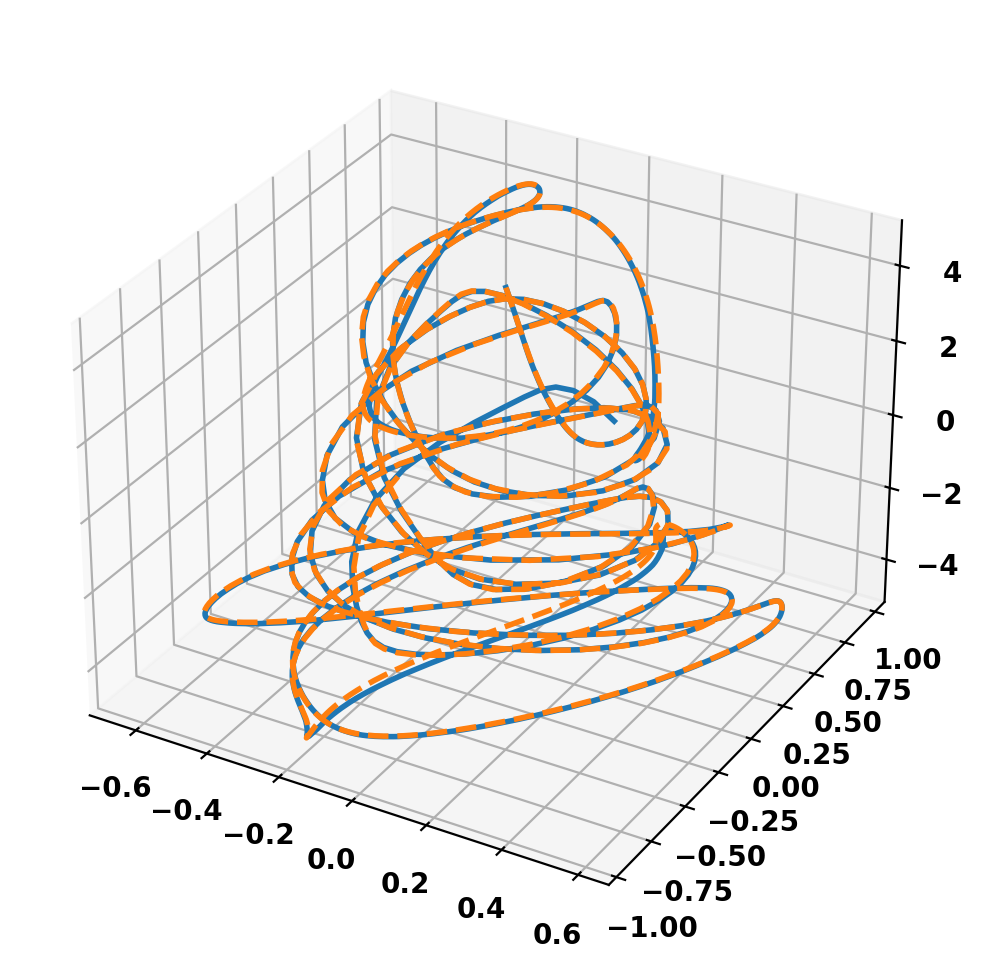

In [10]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(sol[:,0],sol[:,1],sol[:,2])
ax.plot(sol2[:,0],sol2[:,1],sol2[:,2],linestyle='--')
ax.set_aspect('auto')